<a href="https://colab.research.google.com/github/Fassilsis/Titanic-Competition-A-Walkthrough-to-Top-4-Percent/blob/main/Titanic_Competition_Walkthrough_to_Top_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

The Titanic was on a ship bound for New York City on April 15, 1912, when it collided with an iceberg and caused many deaths. An estimated 2,224 passengers and crew were on board. More than 1,500 of them died. When the Titanic entered service, it was the largest ship. 

The main purpose of this notebook is to show how machine learning models can help us predict passenger survival. You can use this notebook to learn the basics of machine learning in Python.

In [173]:
# **Import Libraries**

import os
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [174]:
#Mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [175]:
#Let us get the training and testing datasets. 

train = pd.read_csv('/content/drive/My Drive/Titanic/train.csv')
test = pd.read_csv('/content/drive/My Drive/Titanic/test.csv')

# **Data Exploration**

Now in order to study the structure of our data set, let us perform some data exploration.

In [176]:
categorical = len(train.select_dtypes(include=['object']).columns)
numerical = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total number of variables= ', categorical, 'Categorical', '+',
      numerical, 'Numerical', '=>', categorical+numerical, 'variables')
train.head(10)

Total number of variables=  5 Categorical + 7 Numerical => 12 variables


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


We can see a couple of things in the table above. First, many features are not numeric, so we want to change those features to numeric later. Second, we can see that the features have a wide range of levels that we need to change to the same scale. There are also some features that include missing values (NAN).

The following table describes the numerical features of the training dataset. Generally, 38% of the passengers survived on the Titanic. We also found that the average age of the passengers was around 30 years and ranged from 0.4 to 80 years. We can also see that the fare for passengers is very different, that is, the minimum is 79 and the maximum is 512. The count variable indicates that some features are missing values and we want to fix them. Let's take a look at the relationship between each variable and Survival, and how they relate to one another. 


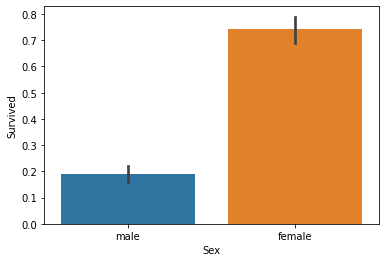

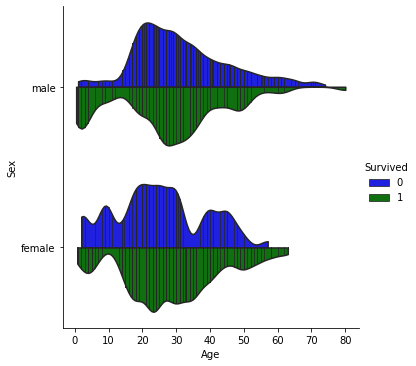

In [177]:
train.describe()

sns.barplot(x=train['Sex'], y=train['Survived']) 


sns.catplot(x="Age", y="Sex", 
            hue="Survived", kind="violin", figsize=(25, 25),
            split=True, inner="stick",
            palette={0: "b", 1: "g"},
            bw=.15, cut=0,
            data=train)

The graphs above contain some useful information. First, men are much more likely to die than women. Second, young men are more likely to survive. To be specific, chances of survival for men under the age of 15 are very high, but not for women. Third, men between the ages of 18 and 30 are more likely to die. Fourth, age in general does not appear to have a direct impact on women's survival. These results show that the principle of priority for women and children in war and disaster was applied to the Titanic.


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

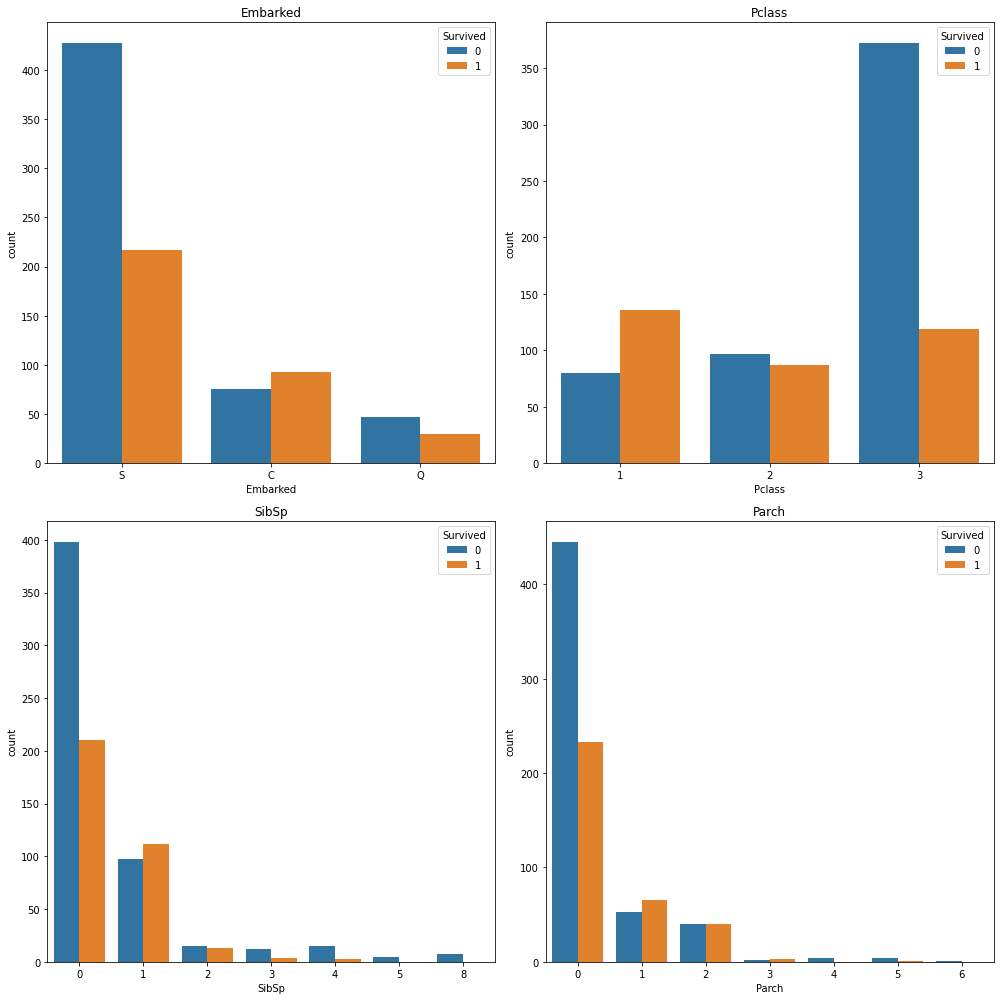

In [178]:
cols = ['Embarked', 'Pclass', 'SibSp', 'Parch']
n_rows = 2
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*7,n_rows*7))

for row in range(0,n_rows):
    for column in range(0,n_cols):  
        i = row*n_cols+ column       
        ax = axs[row][column]
        sns.countplot(train[cols[i]], hue=train["Survived"], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title="Survived", loc='upper right')       
plt.tight_layout() 

From the graphs above, it can be seen that Pclass plays a role in determining the chances of survival. Overall, the higher the Pclass, the lower the chance of survival. For male passengers on P2 and P3, however, their chances of survival seem to be the same. In addition, the ticket price correlates with the Pclass. It seems that the port of entry also has something to do with survival. People who embarked in Port C have a better chance of survival. This pattern applies to both sexes. But, if you think about it, it doesn't make sense, right? How could where you board on the ship affect your servival? I think, Pclass can may have played a mediating role here. As can be seen above, the impact of Port of entery on survival depends on Pclass. Therefore we will consider removing the "Embarked" attribute. 

Next, we'll see how Sibps (i.e. the number of siblings or spouses on board the Titanic) and Parch (the number of parents or children on board the Titanic) are related to the chances of survival. That said, Sibps and Parch are features that indicate that a person has relatives on the Titanic. But, there reports of inconsistencies on these variables. 


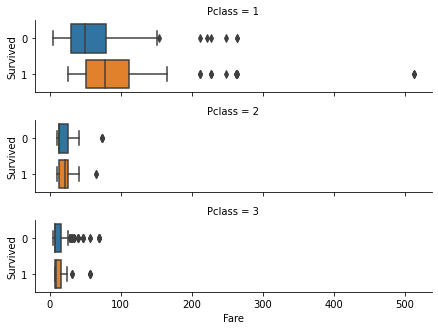

In [179]:
grid = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=4,
                data=train.query("Fare > 0"))


Before we start cleaning the data, let us see the correlation among continious variables. This information is so vital for missng value imputation. 

From the below graph we can observe that that all features are correlated with Survived. However, the correlation between Pclass and Survived is the highest, -0.34. Since all other features are correlated with Pclass it would be fare to assume that they would not add much value. So, it is better to drop SibSp, Parch, Fare and Age.


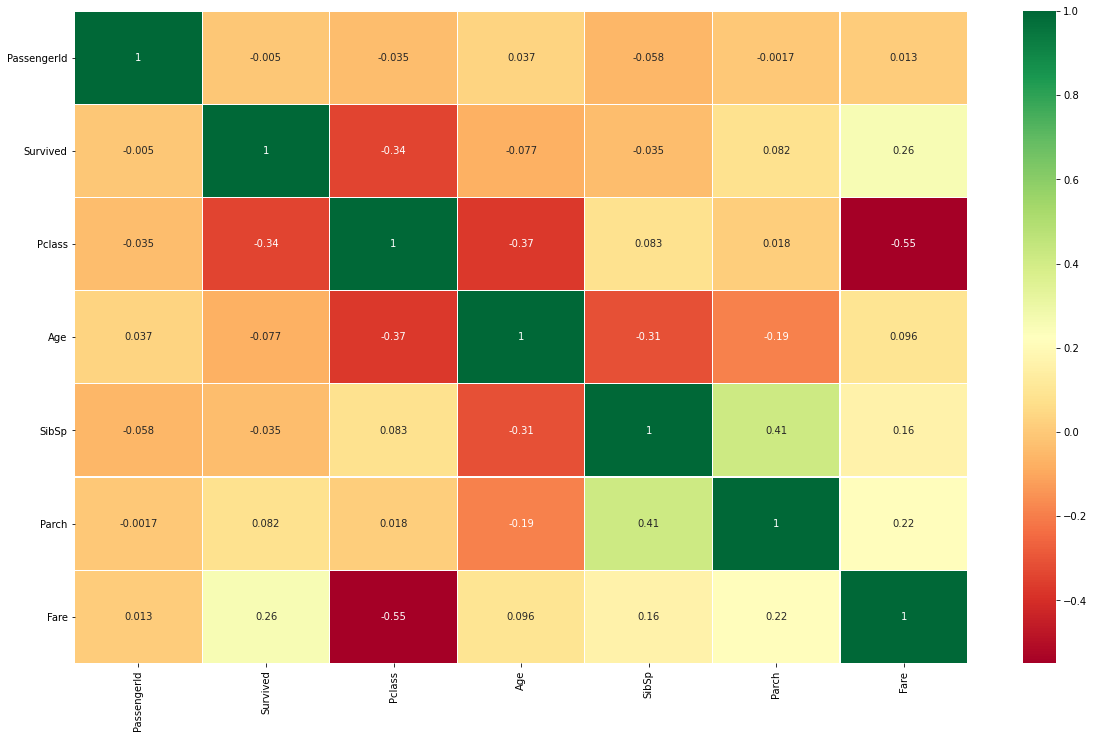

In [180]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

# **Feature Engneering**

To apply the same changes on both the training and testing datasets at the same time, we shall combine them together.

In [181]:
comb = train.append(test)
comb.shape

comb.isnull().sum()/comb.isnull().count()*100 

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64

# **IsFemale**

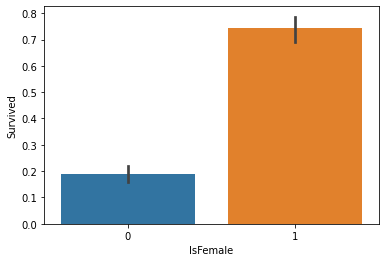

In [182]:
comb['IsFemale'] = np.where(comb['Sex']=='female', 1, 0 )
sns.barplot(x='IsFemale', y='Survived', data=comb) 

# **IsMr**

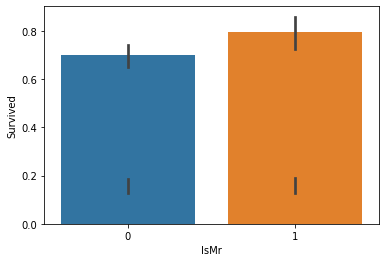

In [183]:
Titles = set()
for name in comb['Name']:
    Titles.add(name.split(',')[1].split('.')[0].strip())
Dict = {"Capt": "Special", "Col": "Special", "Major": "Special", "Jonkheer": "Special","Don": "Special","Dona": "Special",
    "Sir" : "Special", "Dr": "Special", "Rev": "Special", "the Countess":"Special", "Mme": "Mrs", "Mlle": "Miss",
    "Ms": "Mrs", "Mr" : "Mr", "Mrs" : "Mrs", "Miss" : "Miss", "Master" : "Master", "Lady" : "Special"}
def Titles():
    comb['Title'] = comb['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    comb['Title'] = comb.Title.map(Dict)
    return comb
comb = Titles()

sns.barplot(x='Title', y='Survived', data=comb) 
comb['IsMr'] = np.where(comb['Title']=='Mr', 1,0)
sns.barplot(x='IsMr', y='Survived', data=comb) 



From our previous analysis, we know that men are less likely to survive. The above graph adds some additional information. Well, not all men are not equally affected. Those with the title Mr are highly likely to perish. It is wise to create a new feature called IsMr. 

# **Group Formation**


People not only travel with close family members such as siblings and spouses, but also with distant relatives, friends and nannies. These people are not considered a family, but they use the same ticket number. Creating a new group function based on Parch and SibSp may be an option, but I didn't choose to follow this path.

I've decided to create a group as follows I created a new feature that combines the ticket type, embarkation port, and family name. That is, people with the same family name, the same passengers and the same type of ticket are grouped.



In [184]:
#Extract ticket type from Ticket
import string
TicketType = []
for i in range(len(comb.Ticket)):
    ticket = comb.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TicketType.append('NO')
    else: 
                TicketType.append(splited_ticket[0])
comb['TicketType'] = TicketType
comb['TicketType'] = np.where((comb.TicketType!='NO') & (comb.TicketType!='PC') & 
                                (comb.TicketType!='CA') & (comb.TicketType!='A5') & 
                                (comb.TicketType!='SOTONOQ'),'OT',comb.TicketType)


#Extract Crew from Ticket.
comb['Crew'] = np.where(comb.Fare==0, 1, 0)
comb.Crew.value_counts()

#sns.catplot(x='Crew', y='Survived', kind='bar', data=comb)
#Extract LastName from Name
comb['LastName'] = comb['Name'].str.extract('([A-Za-z]+),', expand=False)

#Create a new variable by cencatinatinig TicketType, Embarked, LastName 
comb['Group'] = comb['TicketType'].astype(str) + comb['Embarked'].astype(str) + comb['LastName'].astype(str) 
le = LabelEncoder()
comb['GroupID']  = le.fit_transform(comb['Group'])

# **Ticket Frequency**

Ticket Frequency is a ticket-based feature that includes people who have the same ticket number. This feature can serve as group size as it puts people who travel with the same ticket number together, whether they are related or not. 


In [185]:
comb['TicketFreq'] = comb.groupby('Ticket')['Ticket'].transform('count')

# **Final Data Visualisation**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

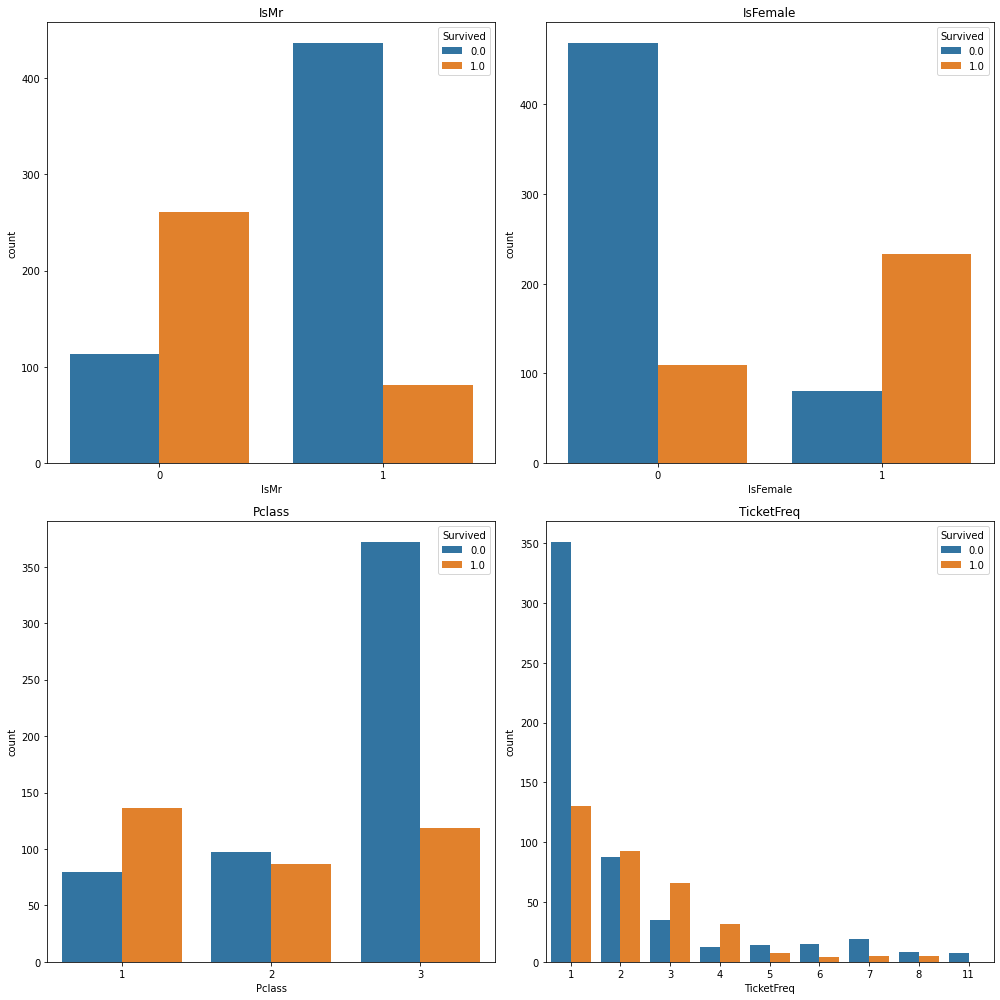

In [186]:
cols = ['IsMr', 'IsFemale', 'Pclass', 'TicketFreq']

n_rows = 2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*7,n_rows*7))

for row in range(0,n_rows):
    for column in range(0,n_cols):  
        i = row*n_cols+ column      
        ax = axs[row][column] 
        sns.countplot(comb[cols[i]], hue=comb["Survived"], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title="Survived", loc='upper right') 
        
plt.tight_layout() 


# Drop unwanted features

In [187]:
comb.drop(['Ticket', 'Sex', 'Title', 'Name', 'Fare', 'Age', 'TicketType', 'LastName', 'Parch', 'SibSp', 'Crew', 
           'Cabin', 'Embarked', 'Group'], axis=1, inplace=True) 
comb.head(5)

,PassengerId,Survived,Pclass,IsFemale,IsMr,GroupID,TicketFreq
0,1,0.0,3,0,1,2,1
1,2,1.0,1,1,0,841,2
2,3,1.0,3,1,0,771,1
3,4,1.0,1,1,0,407,2
4,5,0.0,3,0,1,269,1


# **Model Building**

In this part we will create a statistical model based on the features developed in the previous part. Since the target variable is binary in nature, we will use classification modals. There is a wide variety of models to choose from. We are going to use 7 of them i.e. Logistic Regression, Decision Trees, Random Forests, Gradient Boost, AdaBoost, Support Vector Machines and KNeighbors.


In [188]:
# Import libraries for model building

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import warnings

# **Test-Train Split**

Before we run the models we need to split the combined dataset into training and testing datasets.


In [189]:
n=len(train)
train_df = comb.iloc[:n] 
test_df = comb.iloc[n:]

y_train = train_df['Survived'].astype(int)
X_train = train_df.drop(['Survived', 'PassengerId'], axis=1) 
X_test = test_df.drop(['Survived', 'PassengerId'], axis=1)

# **Cross-Validation**

The following function helps us evaluate our models by returning a data frame that contains useful information based on a 10-fold cross-validation.


In [190]:
def stats(models, X_train, y_train):
    stats = {}
    for name, inst in models.items():
        mscores = []
        model_pipe = make_pipeline(StandardScaler(), inst)
        model_pipe.fit(X_train, y_train)
        acc=round(model_pipe.score(X_train, y_train)* 100, 2)
        mscores.append(acc)
        scores = cross_val_score(model_pipe, X_train, y_train, cv=5, scoring='accuracy')
        acccv=round(scores.mean()* 100, 2)
        mscores.append(acccv)
        mscores.append(scores.std())
        y_train_cv_pred = cross_val_predict(model_pipe, X_train, y_train, cv=5)
        p = round(precision_score(y_train, y_train_cv_pred)* 100, 2)
        s = round(recall_score(y_train, y_train_cv_pred)* 100, 2)
        mscores.append(p)
        mscores.append(s)
        f1 = 2*((p*s)/(p+s))
        mscores.append(f1)
        roc_auc_cvs = round(cross_val_score(model_pipe, X_train, y_train, cv=10, scoring='roc_auc').mean()* 100, 2)
        mscores.append(roc_auc_cvs)
        stats[name] = mscores
    colnames = ['Accuracy','AccuracyCv','StandardDeviation', 'Precision','Sensitivity','F1Score', 'RocAucCv']
    df_ms = pd.DataFrame.from_dict(stats, orient='index', columns=colnames)
    df_msr = df_ms.sort_values(by='Accuracy', ascending=False)
    return df_msr

models = {'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'LogisticRegression': LogisticRegression(),
          'SupportVectorMachines': SVC(random_state=0),
          'RandomForestClassifier': RandomForestClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'DecisionTreeClassifier': DecisionTreeClassifier()}
ModelStat = stats(models, X_train,y_train)
ModelStat

,Accuracy,AccuracyCv,StandardDeviation,Precision,Sensitivity,F1Score,RocAucCv
RandomForestClassifier,99.55,78.34,0.017994,72.09,72.51,72.299390,85.80
DecisionTreeClassifier,99.55,78.00,0.031793,71.14,72.81,71.965313,77.04
GradientBoostingClassifier,88.55,80.69,0.024026,77.60,69.88,73.537944,88.44
KNeighborsClassifier,86.42,82.15,0.022345,78.50,73.68,76.013668,86.49
SupportVectorMachines,83.16,82.38,0.015425,80.94,70.76,75.508430,84.42
AdaBoostClassifier,82.15,79.91,0.021929,74.04,73.39,73.713567,85.82
LogisticRegression,80.70,80.47,0.009228,76.25,71.35,73.718665,85.16


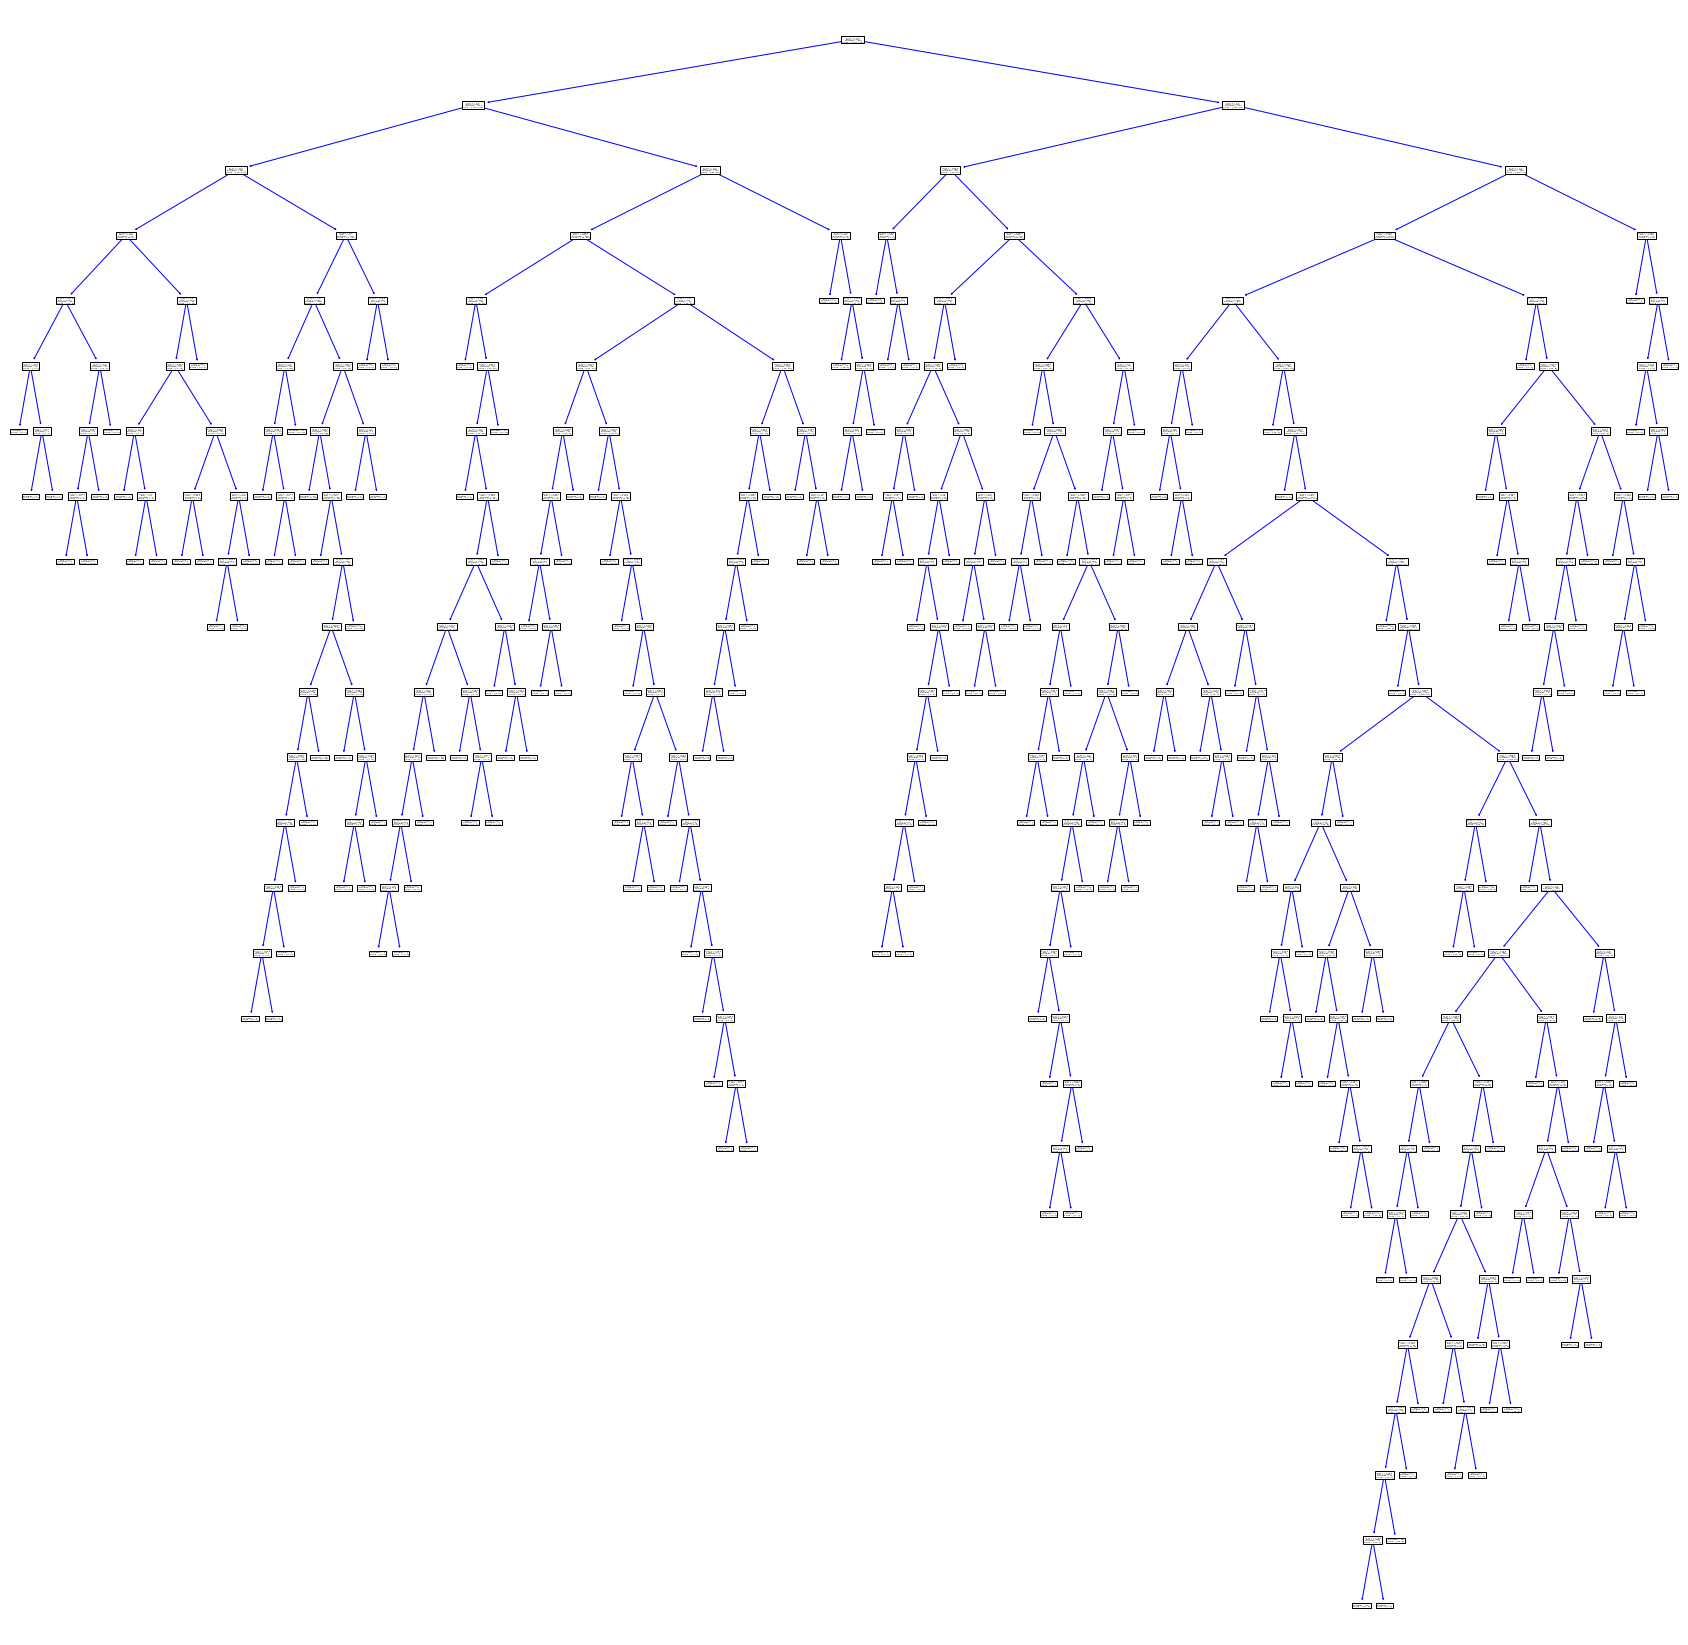

In [191]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(30,30))
out = tree.plot_tree(clf)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('blue')
        arrow.set_linewidth(1)

Decision Forest and Random Forest seem to get high accuracy (99.55%), but when it comes to cross-validation accuracy, they perform poorly.

Instead of choosing one single model, we opt for VotingClassifier. VotingClassifier is a useful method when we have multiple models with different cross-validation scores. It basically combines different machine learning models and applies majority decision (i.e. hard vote) or average predicted probabilities (i.e. soft vote) for the prediction. In our case, we will use a hard vote where the majority is selected. By using hard vote VotingClassifier we will compensate for the weaknesses of some models. 


In [192]:
from sklearn.ensemble import VotingClassifier
BaseVote = VotingClassifier(estimators=[('AdaBoostClassifier', AdaBoostClassifier()),
         ('GradientBoostingClassifier', GradientBoostingClassifier()),
         ('LogisticRegression', LogisticRegression()),
         ('SupportVectorMachines', SVC()),
         ('RandomForest', RandomForestClassifier()),
         ('KNN', KNeighborsClassifier()),
         ('DecisionTree', DecisionTreeClassifier())],
          voting='hard', n_jobs=15)
BaseVote.fit(X_train,y_train)
BaseVote.score(X_train,y_train)
print ('Base Voting Classifier Accuracy Score = {:.2f}%'.format(round(BaseVote.score(X_train,y_train, sample_weight=None)* 100, 2)), 'on', datetime.now())

Base Voting Classifier Accuracy Score = 92.70% on 2020-12-10 19:04:25.043379


#**Hyperparameter tuning**

In [193]:
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV
from sklearn.model_selection import train_test_split 

# define dataset
X = X_train
y = y_train

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1)

#1. Logistic Regression

In [194]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.799110 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


#2. KNN

In [195]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.703258 using {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


#3. SVM

In [196]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.619078 using {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}


#4. RFC

In [197]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.787882 using {'max_features': 'log2', 'n_estimators': 10}


#5. DecisionTreeClassifier

In [198]:
model = DecisionTreeClassifier()
max_depth = [3, None]
criterion = ["gini", "entropy"]
max_features = ['sqrt', 'log2', 'auto']
# define grid search
grid = dict(max_depth=max_depth, criterion=criterion, max_features=max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.799544 using {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt'}


#6. GradientBoostingClassifier

In [199]:
model = GradientBoostingClassifier()
criterion = ['friedman_mse', 'mse', 'mae']
# define grid search
grid = dict(criterion = criterion)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.807636 using {'criterion': 'mse'}


#7. AdaBoosting

In [200]:
model = AdaBoostClassifier()
algorithm = ['AMME', 'SAMME.R']
# define grid search
grid = dict(algorithm=algorithm)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.791923 using {'algorithm': 'SAMME.R'}


### Model evaluation After Tuning

In [201]:
model = {'LogisticRegression': LogisticRegression(C= 0.01, penalty= 'l2', solver= 'newton-cg'),
       'SupportVectorMachines': SVC(probability = True, C= 50, gamma= 'scale', kernel= 'poly'),
       'RandomForestClassifier': RandomForestClassifier(max_features= 'sqrt', n_estimators= 10),
       'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'gini', max_depth= 3, max_features= 'auto'),
       'GradientBoostingClassifier': GradientBoostingClassifier(criterion = 'friedman_mse'),
       'KNeighborsClassifier': KNeighborsClassifier(weights='distance', metric='manhattan', n_neighbors=5),
       'AdaBoostClassifier': AdaBoostClassifier (algorithm = 'SAMME.R')}

ModelStatAfterHT = stats(model, X_train,y_train)
ModelStatAfterHT

,Accuracy,AccuracyCv,StandardDeviation,Precision,Sensitivity,F1Score,RocAucCv
KNeighborsClassifier,99.55,81.59,0.018127,77.30,73.68,75.446602,86.84
RandomForestClassifier,97.98,79.80,0.016114,74.15,70.47,72.263179,84.61
GradientBoostingClassifier,88.55,80.69,0.024026,77.60,69.88,73.537944,88.42
SupportVectorMachines,83.84,82.60,0.026938,80.06,72.81,76.263081,84.76
AdaBoostClassifier,82.15,79.91,0.021929,74.04,73.39,73.713567,85.82
DecisionTreeClassifier,79.12,81.93,0.018185,76.66,71.05,73.748467,84.21
LogisticRegression,78.79,78.90,0.014623,73.48,70.47,71.943530,85.19


# Voting Classifier

Get a voting ensemble of models after hyperparameter tuning

In [202]:
FinalVote = VotingClassifier(estimators=[('LogisticRegression', LogisticRegression(C= 0.01, penalty= 'l2', solver= 'newton-cg')),
       ('SVC', SVC(probability = True, C= 0.1, gamma= 'scale', kernel= 'sigmoid')),
       ('RandomForestClassifier', RandomForestClassifier(max_features= 'log2', n_estimators= 1000)),
       ('DecisionTreeClassifier', DecisionTreeClassifier(criterion= 'entropy', max_depth= None, max_features= 'sqrt')),
       ('GradientBoostingClassifier', GradientBoostingClassifier(criterion = 'friedman_mse')),
       ('KNeighborsClassifier', KNeighborsClassifier(weights='uniform', metric='euclidean', n_neighbors=19)),
       ('AdaBoostClassifier', AdaBoostClassifier(algorithm = 'SAMME.R'))], voting='hard', n_jobs=15)
FinalVote.fit(X, y)
prediction_vote=FinalVote.predict(X_test)
print ('Final Voting Classifier Accuracy Score = {:.2f}%'.format(round(FinalVote.score(X,y, sample_weight=None)* 100, 2)), 'on', datetime.now())

Final Voting Classifier Accuracy Score = 91.25% on 2020-12-10 19:05:42.474074



#**Submission**



In [ ]:
output= pd.DataFrame (pd.DataFrame({
    "PassengerId": test_df["PassengerId"], "Survived": prediction_vote}))
output.head()
output.to_csv('FinalSubmission.csv', index=False)

The Voting Classifier helps me be on the top 4% on Leaderboard with an accuracy score of 0.80382 on competition test dataset.